# Stock Index Time Series

In [1]:
!pip install yfinance
!pip install --upgrade statsmodels
!pip install prophet

In [2]:
import os 
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from pprint import pprint

In [3]:
import warnings
warnings.filterwarnings('ignore')

## The google drive mounting is for using local library

In [4]:
# Mount your google drive in google colab
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # Insert the directory to syspath
    import sys
    sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks')
except:
    pass

In [5]:
from time_series_utils import timeseries_evaluation_metrics_func, timeseries_RMSE_calc, \
                          create_proph_train_test, find_best_Prophet_model, \
                          find_best_ETS_model, find_best_ARIMA_model, find_best_SARIMAX_model

Importing plotly failed. Interactive plots will not work.


## S&P 500 index (SPY) Time series

In [6]:
ticker = yf.download("SPY", start='2005-01-01')
ticker['Date'] = ticker.index
ticker.head()

[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close  Adj Close  \
Date                                                                    
2004-12-31  121.300003  121.660004  120.800003  120.870003  86.411942   
2005-01-03  121.559998  121.760002  119.900002  120.300003  86.004410   
2005-01-04  120.459999  120.540001  118.440002  118.830002  84.953491   
2005-01-05  118.739998  119.250000  118.000000  118.010002  84.367279   
2005-01-06  118.440002  119.150002  118.260002  118.610001  84.796219   

              Volume       Date  
Date                             
2004-12-31  28648800 2004-12-31  
2005-01-03  55748000 2005-01-03  
2005-01-04  69167600 2005-01-04  
2005-01-05  65667300 2005-01-05  
2005-01-06  47814700 2005-01-06

In [7]:
ticker.head()

Open        High         Low       Close  Adj Close  \
Date                                                                    
2004-12-31  121.300003  121.660004  120.800003  120.870003  86.411942   
2005-01-03  121.559998  121.760002  119.900002  120.300003  86.004410   
2005-01-04  120.459999  120.540001  118.440002  118.830002  84.953491   
2005-01-05  118.739998  119.250000  118.000000  118.010002  84.367279   
2005-01-06  118.440002  119.150002  118.260002  118.610001  84.796219   

              Volume       Date  
Date                             
2004-12-31  28648800 2004-12-31  
2005-01-03  55748000 2005-01-03  
2005-01-04  69167600 2005-01-04  
2005-01-05  65667300 2005-01-05  
2005-01-06  47814700 2005-01-06

We will focus on the 'Adj Close' in our analysis 

In [8]:
ticker = ticker[['Adj Close']]
ticker.head() 

Adj Close
Date                 
2004-12-31  86.411942
2005-01-03  86.004410
2005-01-04  84.953491
2005-01-05  84.367279
2005-01-06  84.796219

In [9]:
ticker = ticker.rename(columns={'Adj Close': 'Adj_Close'})
ticker.tail()

Adj_Close
Date                  
2022-04-18  437.970001
2022-04-19  445.040009
2022-04-20  444.709991
2022-04-21  438.059998
2022-04-22  426.040009

In [10]:
# fwd fill any NA value
ticker = ticker.ffill()

In [11]:
# lets change it to weekly
df = ticker.resample(rule='W').sum()
df.tail(), ticker.tail()

(              Adj_Close
 Date                   
 2022-03-27  2240.959991
 2022-04-03  2280.720032
 2022-04-10  2250.689972
 2022-04-17  1759.310028
 2022-04-24  2191.820007,
              Adj_Close
 Date                  
 2022-04-18  437.970001
 2022-04-19  445.040009
 2022-04-20  444.709991
 2022-04-21  438.059998
 2022-04-22  426.040009)

<AxesSubplot:xlabel='Date'>

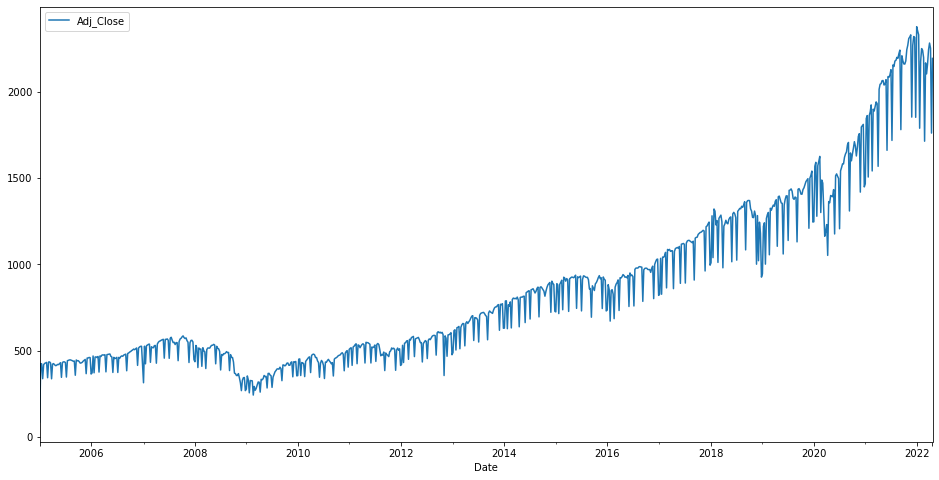

In [12]:
df.plot(figsize=(16,8))

In [13]:
df.index

DatetimeIndex(['2005-01-02', '2005-01-09', '2005-01-16', '2005-01-23',
               '2005-01-30', '2005-02-06', '2005-02-13', '2005-02-20',
               '2005-02-27', '2005-03-06',
               ...
               '2022-02-20', '2022-02-27', '2022-03-06', '2022-03-13',
               '2022-03-20', '2022-03-27', '2022-04-03', '2022-04-10',
               '2022-04-17', '2022-04-24'],
              dtype='datetime64[ns]', name='Date', length=904, freq='W-SUN')

In [14]:
from datetime import datetime, timedelta
train_dataset_end = datetime(2020,12,31)
test_dataset_end = datetime(2022,4,7)

In [15]:
train_data = df[:train_dataset_end]
test_data = df[train_dataset_end+timedelta(days=7):test_dataset_end]

In [16]:
test_data

Adj_Close
Date                   
2021-01-10  1843.650604
2021-01-17  1860.748871
2021-01-24  1504.863129
2021-01-31  1859.647095
2021-02-07  1882.510223
...                 ...
2022-03-06  2165.652191
2022-03-13  2102.109528
2022-03-20  2159.053589
2022-03-27  2240.959991
2022-04-03  2280.720032

[65 rows x 1 columns]

In [17]:
# Value Columns to be used in all models tuning
val_col = 'Adj_Close'

In [18]:
# freq, and date_col for Prophet
ph_freq='W' # weekly accumulative
ph_date_col='Date'

## Holt Winters Exponential Smoothings (ETS) Model

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [20]:
# check seasonal period quarter, or yesrly
best_ETS_model, best_RMSE, best_ETS_params = find_best_ETS_model(train_data, test_data,\
                                                                 val_col=val_col, seasonal_periods=[13,52])

In [21]:
best_RMSE, best_ETS_params

(215.67135737386334, ('mul', 'add', 52))

(215.67135737386334, ('mul', 'add', 52))

In [22]:
test_pred_ETS = best_ETS_model.forecast(len(test_data))
test_pred_ETS

2021-01-03    1517.747271
2021-01-10    1827.486873
2021-01-17    1807.088006
2021-01-24    1582.636161
2021-01-31    1857.019375
                 ...     
2022-02-27    2161.757607
2022-03-06    2166.421963
2022-03-13    2093.299284
2022-03-20    2040.265222
2022-03-27    2074.625505
Freq: W-SUN, Length: 65, dtype: float64

In [23]:
test_data['Predicted_ETS'] = test_pred_ETS

<AxesSubplot:xlabel='Date'>

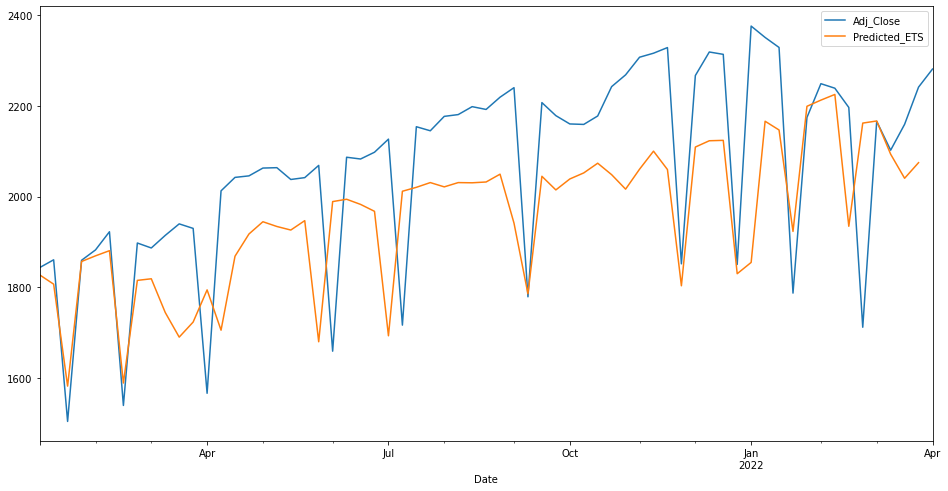

In [24]:
test_data[[val_col, 'Predicted_ETS']].plot(figsize=(16,8))

## ARIMA Model

In [25]:
## create an ARIMA model
from statsmodels.tsa.arima.model import ARIMA

In [26]:
best_ARIMA_model, best_RMSE, best_pdq = find_best_ARIMA_model(train_data, test_data, val_col=val_col, p=range(0,9), d=range(1,3), q=range(0,9))

C:\Users\wismi\miniconda3\envs\TorchEnv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wismi\miniconda3\envs\TorchEnv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wismi\miniconda3\envs\TorchEnv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wismi\miniconda3\envs\TorchEnv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wismi\miniconda3\envs\TorchEnv\

In [27]:
best_pdq, best_RMSE

((15, 1, 13), 351.38845236160216)

(15, 1, 13), 351.38845236160216

In [28]:
test_pred_arima = best_ARIMA_model.predict(start=test_data.index[0], end=test_data.index[-1])

In [29]:
test_data['Predicted_ARIMA'] = test_pred_arima

<AxesSubplot:xlabel='Date'>

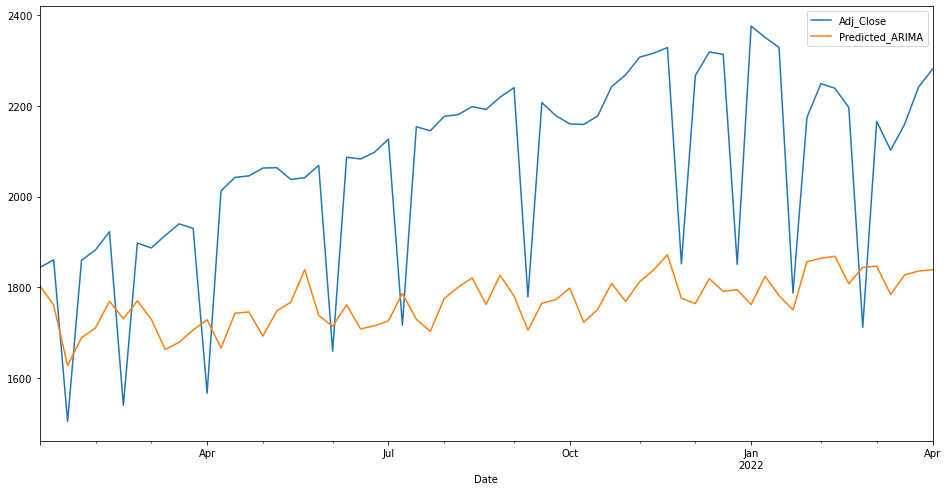

In [30]:
test_data[[val_col, 'Predicted_ARIMA']].plot(figsize=(16,8))

## SARIMAX Model

In [31]:
# create a SARIMAX model 
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [32]:
# we get best pdq from ARIMA (=best_pdq) and seaonal_period from ETS best params
seasonal_period = best_ETS_params[2]

In [33]:
best_SARIMAX_model, best_RMSE, best_PDQS = find_best_SARIMAX_model(train_data, test_data, best_pdq, \
                                                                  val_col=val_col, season_period=seasonal_period)

C:\Users\wismi\miniconda3\envs\TorchEnv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
best_RMSE, best_PDQS

(351.38845236160216, (0, 0, 0, 52))

In [35]:
pred_test_SARIMAX = best_SARIMAX_model.predict(start=test_data.index[0], end=test_data.index[-1])

In [36]:
test_data['Predicted_SARIMAX'] = pred_test_SARIMAX

<AxesSubplot:xlabel='Date'>

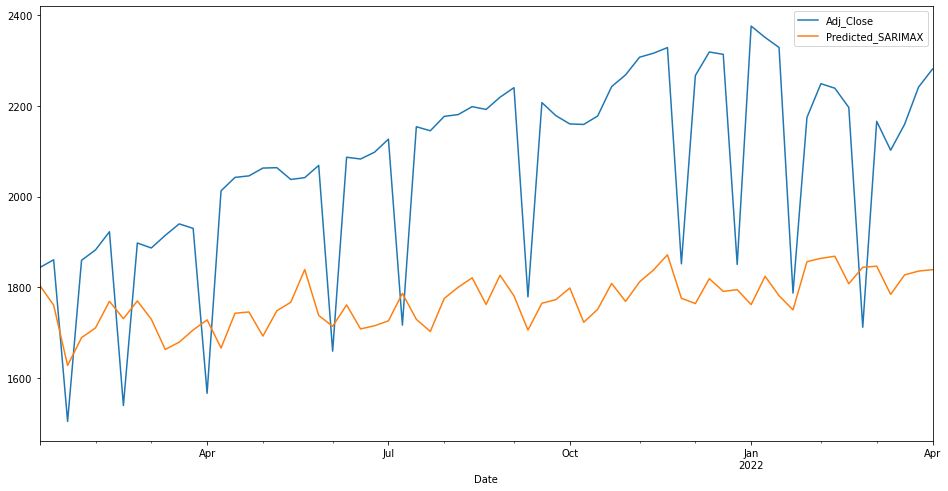

In [37]:
test_data[[val_col, 'Predicted_SARIMAX']].plot(figsize=(16,8))

## Prophet

In [38]:
from prophet import Prophet

In [39]:
proph_train, proph_test = create_proph_train_test(train_data, test_data, date_col=ph_date_col, val_col=val_col)

In [40]:
best_Prophet_model, best_RMSE, best_Prophet_params = find_best_Prophet_model(
    proph_train, proph_test, test_data, val_col=val_col,freq=ph_freq, n_changepoints=[25, 50])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

In [41]:
best_Prophet_params, best_RMSE

(('linear', 50, 'additive', 10), 451.22195657385294)

(('linear', 50, 'additive', 10), 451.22195657385294)

In [42]:
future = best_Prophet_model.make_future_dataframe(periods=len(proph_test), freq=ph_freq)
forecast = best_Prophet_model.predict(future)

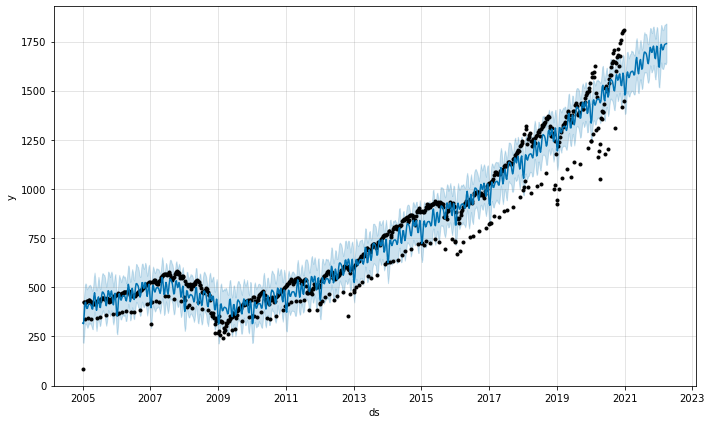

In [43]:
fig1 = best_Prophet_model.plot(forecast)

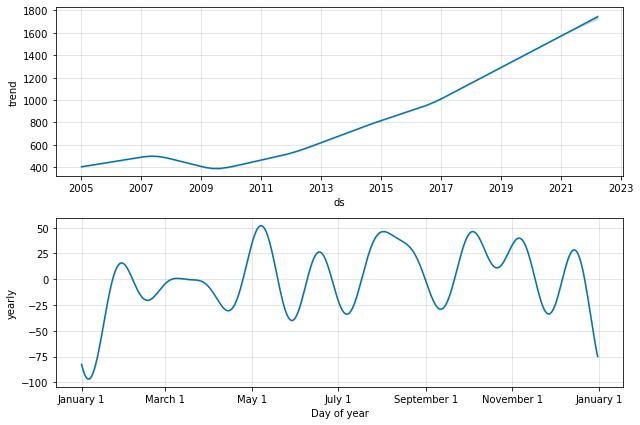

In [44]:
fig2 = best_Prophet_model.plot_components(forecast)

In [45]:
test_data['Predicted_Prophet'] = forecast[-(len(proph_test)):][['ds', 'yhat']].set_index('ds')

<AxesSubplot:xlabel='Date'>

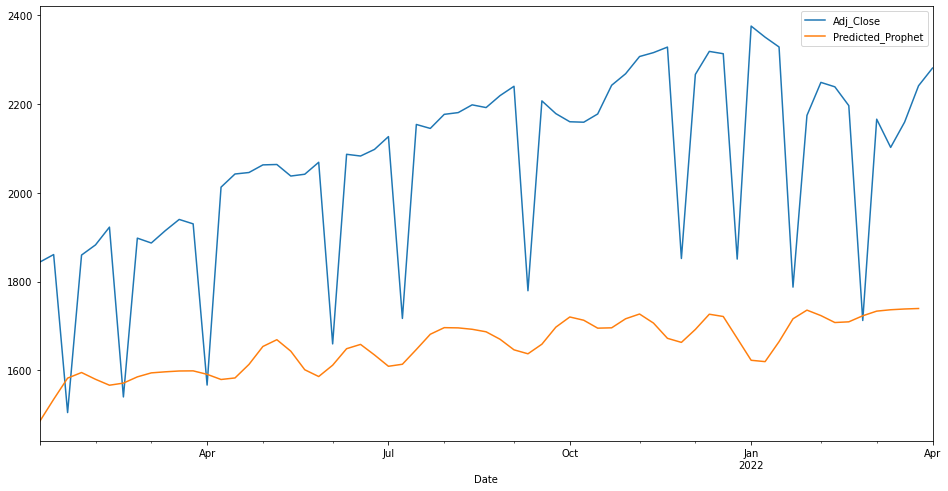

In [46]:
test_data[[val_col, 'Predicted_Prophet']].plot(figsize=(16,8))

## Metrics

In [49]:
test_data = test_data.ffill(axis=0)

In [50]:
timeseries_evaluation_metrics_func(test_data.Adj_Close, test_data.Predicted_ETS)

Evaluation metric results:-
Mean Square Error is : 37016.264112359524
Mean Absolute Error is : 156.86033633593777
Root Mean Square Error is : 192.3961125188332
Mean Absolute Percentage Error is : 7.589404278336131
R2 score is : 0.16149978953594224



In [51]:
timeseries_evaluation_metrics_func(test_data.Adj_Close, test_data.Predicted_ARIMA)

Evaluation metric results:-
Mean Square Error is : 123473.84445308194
Mean Absolute Error is : 319.3815647974618
Root Mean Square Error is : 351.38845236160216
Mean Absolute Percentage Error is : 14.940215556582364
R2 score is : -1.7969555286954657



In [52]:
timeseries_evaluation_metrics_func(test_data.Adj_Close, test_data.Predicted_SARIMAX)

Evaluation metric results:-
Mean Square Error is : 123473.84445308194
Mean Absolute Error is : 319.3815647974618
Root Mean Square Error is : 351.38845236160216
Mean Absolute Percentage Error is : 14.940215556582364
R2 score is : -1.7969555286954657



In [53]:
timeseries_evaluation_metrics_func(test_data.Adj_Close, test_data.Predicted_Prophet)

Evaluation metric results:-
Mean Square Error is : 201427.78556466842
Mean Absolute Error is : 414.54570087974326
Root Mean Square Error is : 448.8070694236761
Mean Absolute Percentage Error is : 19.394027669302176
R2 score is : -3.562784620204007



### Conclusion: 

Based on MSE and MAE values, the ETS model provide the best prediction and the only model with positive R2 values. Eventhough it's quite small positive. 

Ranking of the models are: ETS, ARIMA/SARIMAX, Prophet